In [ ]:
! pip install "abc_atlas_access[notebooks] @ git+https://github.com/alleninstitute/abc_atlas_access.git"

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache
from scipy import sparse
import pynndescent

import sys
sys.path.insert(0, str(Path("..").resolve()))
import mapping_sc_to_st

## Example data: Allen Brain Cell Atlas (ABC Atlas) – mouse motor cortex (MOp)

This notebook **downloads a small, region-restricted subset** of public datasets from the **Allen Brain Cell Atlas (ABC Atlas)** using `abc_atlas_access`, and prepares two `AnnData` objects that the second notebook uses:

- **Spatial (ST):** MERFISH dataset (Zhuang lab / ABC Atlas), restricted to the **MOp** (primary motor cortex) region of interest.
- **Single-cell (SC):** Whole-brain mouse transcriptomic atlas (WMB; 10X v3), restricted to the same **MOp** region of interest.

At the end, we export:
- `adata_st_mouse_brain_MOp.h5ad` (spatial cells + coordinates/metadata)
- `adata_sc_mouse_brain_MOp.h5ad` (single-cell representation used in the example)


### Minimal Requirements
- single-cell: cell type annotations
- spatial data: spatial coordinates


In [2]:
import os
from pathlib import Path

# --- portable paths ---
BASE_DIR = Path(os.environ.get('MAPPING_SC_TO_ST_DATA', './data')).resolve()
CACHE_DIR = (BASE_DIR / 'abc_cache')
EXPORT_DIR = (BASE_DIR / 'exports')
CACHE_DIR.mkdir(parents=True, exist_ok=True)
EXPORT_DIR.mkdir(parents=True, exist_ok=True)


In [3]:
# ABC Atlas cache object (downloads into CACHE_DIR)
from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

cache = AbcProjectCache.from_cache_dir(CACHE_DIR)

# --- dataset identifiers (ABC Atlas) ---
MERFISH_DIR = 'Zhuang-ABCA-4'      # MERFISH spatial transcriptomics (mouse)
SC_META_DIR = 'WMB-10X'           # single-cell metadata
SC_MATRIX_DIR = 'WMB-10Xv3'       # single-cell expression matrices (10X v3)

# --- example region ---
TARGET_STRUCTURE = 'MOp'          # Allen acronym
TARGET_ROI = 'MOp'
PREFER_RAW = True                # prefer raw counts when available


In [4]:
cell = cache.get_metadata_dataframe(
    directory=MERFISH_DIR, file_name="cell_metadata", dtype={"cell_label": str}
).set_index("cell_label")

ccf = cache.get_metadata_dataframe(
    directory=f"{MERFISH_DIR}-CCF", file_name="ccf_coordinates", dtype={"cell_label": str}
).set_index("cell_label").rename(columns={"x":"x_ccf","y":"y_ccf","z":"z_ccf"})

parc = cache.get_metadata_dataframe(
    directory="Allen-CCF-2020",
    file_name="parcellation_to_parcellation_term_membership_acronym",
).set_index("parcellation_index")
parc.columns = [f"parcellation_{c}" for c in parc.columns]  # division/structure/substructure

meta = cell.join(ccf, how="inner").join(parc, on="parcellation_index", how="left")

section_col = "brain_section_label"
structure_col = "parcellation_structure"

mop_cells = meta[meta[structure_col] == TARGET_STRUCTURE].copy()

chosen_section = mop_cells[section_col].value_counts().idxmax()

sec = meta[meta[section_col] == chosen_section].copy()
merfish_region = sec[sec[structure_col] == TARGET_STRUCTURE].copy()

In [5]:
st_keys = cache.list_expression_matrix_files(MERFISH_DIR)
st_key = ([k for k in st_keys if k.endswith("/raw")] or st_keys)[0]

st_path = Path(cache.get_file_path(MERFISH_DIR, st_key)).resolve()
adata_st = ad.read_h5ad(st_path, backed="r")

# toy ids
if "cell_label" in adata_st.obs.columns:
    st_ids = adata_st.obs["cell_label"].astype(str).to_numpy()
else:
    st_ids = adata_st.obs_names.astype(str).to_numpy()

keep = np.isin(st_ids, merfish_region.index.astype(str).to_numpy())
adata_st_toy = adata_st[keep, :].to_memory()

toy_ids = (adata_st_toy.obs["cell_label"].astype(str)
           if "cell_label" in adata_st_toy.obs.columns
           else adata_st_toy.obs_names.astype(str))

coords2d = ccf.reindex(toy_ids)[["x_ccf","y_ccf"]]
coords3d = ccf.reindex(toy_ids)[["x_ccf","y_ccf","z_ccf"]]

adata_st_toy.obsm["spatial"] = coords2d.to_numpy()
adata_st_toy.obsm["spatial_3d"] = coords3d.to_numpy()

add_cols_st = [c for c in ["parcellation_division","parcellation_structure","parcellation_substructure"] if c in sec.columns]
st_meta_add = sec[add_cols_st].copy()
st_meta_add.index = st_meta_add.index.astype(str)
st_meta_add = st_meta_add.reindex(toy_ids)

for c in add_cols_st:
    adata_st_toy.obs[c] = st_meta_add[c].to_numpy()


In [6]:
sc_meta = cache.get_metadata_dataframe(
    directory=SC_META_DIR, file_name="cell_metadata", dtype={"cell_label": str}
)

roi_col = "region_of_interest_acronym"
pkg_col = "feature_matrix_label"
target_roi = "MOp" 
sc_roi = sc_meta[sc_meta[roi_col].astype(str) == str(target_roi)].copy()

sc_roi_v3 = sc_roi[sc_roi[pkg_col].astype(str).str.startswith("WMB-10Xv3-")].copy()
top_pkg = sc_roi_v3[pkg_col].value_counts().idxmin()  # e.g. "WMB-10Xv3-TH"
print("[SC] ROI =", target_roi, "cells =", sc_roi_v3.shape[0])
print("[SC] chosen package =", top_pkg)

keys = cache.list_expression_matrix_files(SC_MATRIX_DIR)
cand = f"{top_pkg}/raw"

sc_path = Path(cache.get_file_path(SC_MATRIX_DIR, cand)).resolve()
adata_sc = ad.read_h5ad(sc_path, backed="r")
print("[SC] adata:", adata_sc)

[SC] ROI = MOp cells = 124501
[SC] chosen package = WMB-10Xv3-Isocortex-2
[SC] adata: AnnData object with n_obs × n_vars = 228228 × 32285 backed at '/local/users/dlee/ST/data/test_data/expression_matrices/WMB-10Xv3/20230630/WMB-10Xv3-Isocortex-2-raw.h5ad'
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
    var: 'gene_symbol'


In [7]:
if ("cell_barcode" in adata_sc.obs.columns) and ("library_label" in adata_sc.obs.columns):
    sc_meta2 = cache.get_metadata_dataframe(
        directory=SC_META_DIR, file_name="cell_metadata_with_cluster_annotation", dtype={"cell_label": str}
    )
    add_cols = [c for c in ["class","subclass","supertype","cluster","cluster_alias","neurotransmitter"] if c in sc_meta2.columns]
    sc_meta_small = sc_meta2[["cell_barcode","library_label"] + add_cols].drop_duplicates(["cell_barcode","library_label"])
    sc_meta_small = sc_meta_small.set_index(["cell_barcode","library_label"])

    obs = adata_sc.obs.copy()
    key = pd.MultiIndex.from_frame(obs[["cell_barcode","library_label"]])
    joined = sc_meta_small.reindex(key)

    for c in add_cols:
        adata_sc.obs[c] = joined[c].to_numpy()

    print("[SC] added cols:", add_cols)

/home/dlee/miniforge3/envs/env_test/lib/python3.10/site-packages/abc_atlas_access/abc_atlas_cache/abc_project_cache.py:643: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path, **kwargs)


[SC] added cols: ['class', 'subclass', 'supertype', 'cluster', 'cluster_alias', 'neurotransmitter']


In [8]:
adata_sc.obs['cell_type'] = adata_sc.obs['subclass']
del adata_sc.obs['subclass']

In [16]:
adata_sc = adata_sc.to_memory()

In [18]:
sc.pp.filter_genes(adata_sc, min_cells=30)

sc.pp.highly_variable_genes(
    adata_sc,
    flavor="seurat_v3",
    n_top_genes=6000,    
    batch_key= None,  
    subset=False,
    inplace=True
)

In [19]:
print("HVG selected:", int(adata_sc.var["highly_variable"].sum()))

HVG selected: 6000


In [21]:
adata_hvg = adata_sc[:, adata_sc.var["highly_variable"]].copy()

In [22]:
_ = mapping_sc_to_st.prep.ensure_all_basic(
        adata_hvg,
        adata_st_toy,
        st_xy_cols=None,     

        make_spatial_normed=True,   
        spatial_k=10,

        make_scvi=True,            
        scvi_batch_key=None,    
        scvi_counts_layer="counts", 
        scvi_n_latent=512,
        scvi_max_epochs=100,

        make_scvi_st=True,         
        scvi_st_batch_key=None,     
        scvi_st_n_latent=64,
        scvi_st_max_epochs=100,
        scvi_st_counts_layer="counts",
        st_latent_key="X_scvi",
        model_device = 'gpu',
        accelerator = 'gpu',
        devices = [3],
        make_umap_st=True,
        make_umap_sc=True,
    )

/home/dlee/miniforge3/envs/env_test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 0
/home/dlee/miniforge3/envs/env_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/dlee/miniforge3/envs/env_test/lib/python3.10/s ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


start make_scvi


/home/dlee/miniforge3/envs/env_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/dlee/miniforge3/envs/env_test/lib/python3.10/s ...
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/dlee/miniforge3/envs/env_test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `

Epoch 100/100: 100%|██████████| 100/100 [40:40<00:00, 25.04s/it, v_num=1, train_loss_step=3.24e+3, train_loss_epoch=2.99e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [40:40<00:00, 24.41s/it, v_num=1, train_loss_step=3.24e+3, train_loss_epoch=2.99e+3]


Seed set to 0
/home/dlee/miniforge3/envs/env_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/dlee/miniforge3/envs/env_test/lib/python3.10/s ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/home/dlee/miniforge3/envs/env_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/dlee/miniforge3/envs/

Epoch 100/100: 100%|██████████| 100/100 [00:30<00:00,  3.48it/s, v_num=1, train_loss_step=458, train_loss_epoch=449]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [00:30<00:00,  3.28it/s, v_num=1, train_loss_step=458, train_loss_epoch=449]


In [24]:
adata_sc.obsm['X_scvi'] = adata_hvg.obsm['X_scvi']
adata_sc.obsm['X_umap'] = adata_hvg.obsm['X_umap']

In [25]:
n_cats = len(adata_sc.obs['cell_type'].unique())
palette = sns.color_palette("husl", n_cats).as_hex()

adata_sc.uns['cell_type_colors'] = palette

cell_types = adata_sc.obs['cell_type'].unique()
colors = adata_sc.uns['cell_type_colors']

cell_type_color = pd.DataFrame({
    'cell_type': cell_types,
    'color': colors
})

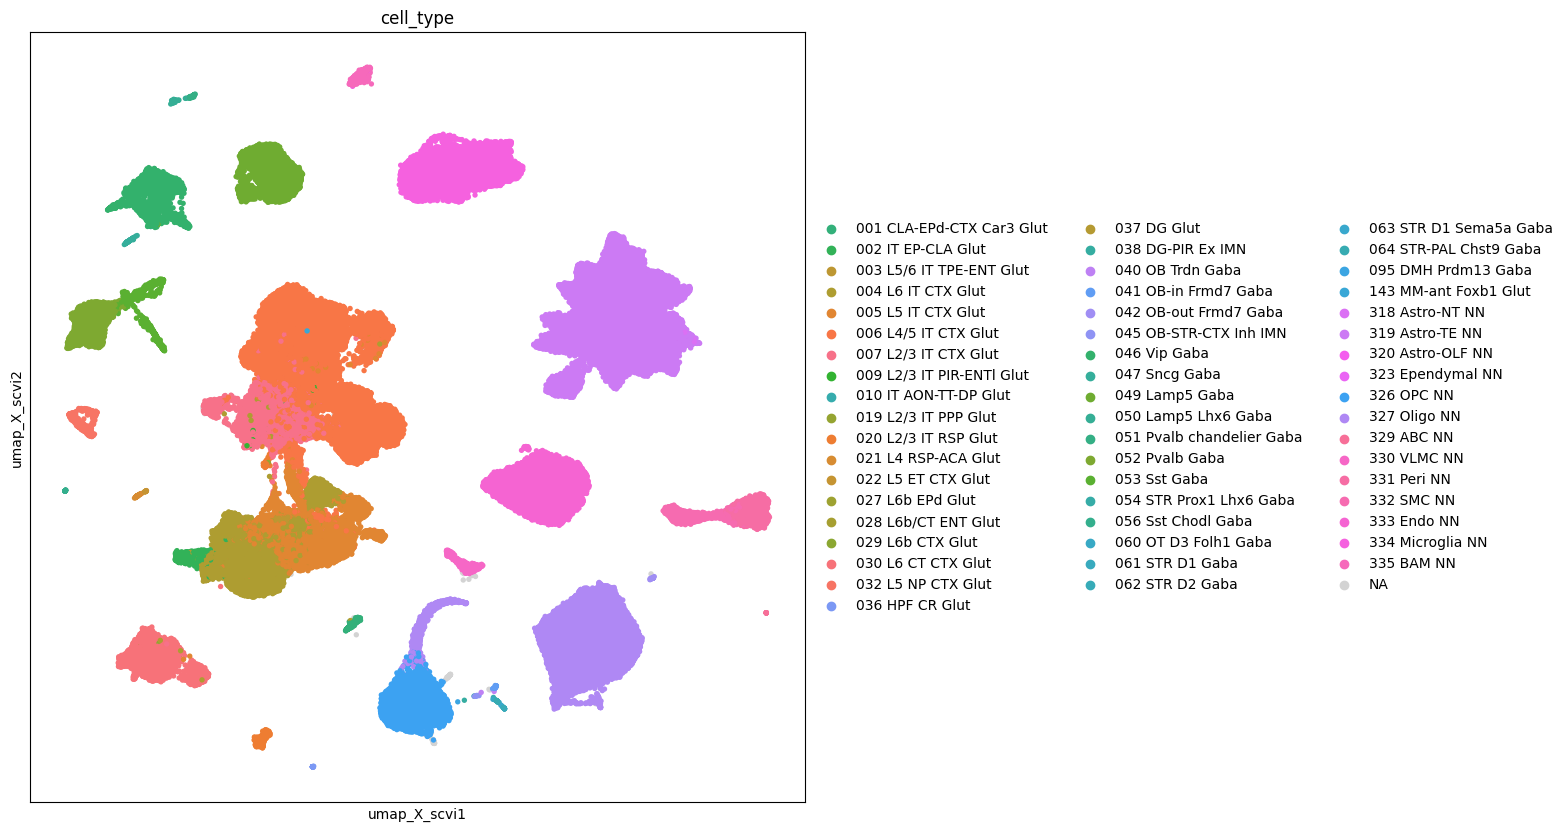

In [26]:
_ = mapping_sc_to_st.fig.plot_rep_umap_pca(adata_sc, color_df = cell_type_color, do_pca = False)

## Metacell Construction (Greedy Aggregation)

To reduce computational cost when the single-cell reference dataset is large, we aggregate similar cells into **metacells**.

A metacell represents a small group of nearby cells using:

- Mean expression profile  
- Mean embedding coordinate (e.g., scVI latent space)

### Method

1. Build a kNN graph in embedding space (`adata.obsm[rep_key]`).  
2. Greedily form groups from unassigned seed cells using a distance threshold.  
3. Attach remaining cells to the nearest metacell centroid.  
4. Aggregate expression (mean or sum) and compute centroid embeddings.

This is a single-pass greedy grouping method (not iterative clustering).

### Output

- `metacell_id`: assignment per original cell  
- `mc_adata`: metacell-level `AnnData` with aggregated expression and embedding  
- `info`: summary statistics and parameters  

In [ ]:
def make_metacell(
    adata,
    # ---- key / io ----
    rep_key="X_scvi",
    celltype_key="auto",         
    obs_key="metacell",
    layer="auto",                 
    expr_mode="mean",             
    drop_unassigned=True,        
    # ---- grouping params ----
    target_size=20,
    min_size=10,
    max_dist="auto",             
    attach_dist="auto",           
    n_neighbors=80,
    # auto distance quantile
    auto_dist_k=None,            
    auto_dist_quantile=0.85,     
    # ---- runtime ----
    random_state=42,
    attach_batch_size=4096,
    # ---- leftover force-assign ----
    force_assign_leftover=True,   
    force_ignore_size_limit=True,
    # ---- misc ----
    store_member_cells=True     
):
    """
    Returns
    -------
    metacell_id : np.ndarray[int32], shape (n_cells,)
    info        : dict
    mc_adata    : AnnData (metacell-level)
    """

    X = np.asarray(adata.obsm[rep_key], dtype=np.float32, order="C")
    n_cells, n_dim = X.shape

    if celltype_key == "auto":
        ct_candidates = ["cell_type", "celltype", "CellType", "annotation", "annot", "label", "labels"]
        celltype_key_used = next((k for k in ct_candidates if k in adata.obs.columns), None)
    else:
        celltype_key_used = celltype_key

    if layer == "auto":
        layer_used = "counts" if "counts" in adata.layers.keys() else None
    else:
        layer_used = layer

    M = adata.layers[layer_used] if layer_used is not None else adata.X

    n_neighbors = int(min(max(n_neighbors, target_size), n_cells))
    min_size = int(min(min_size, target_size))
    if min_size < 1:
        min_size = 1

    # ---------------------------
    # 1) ANN graph (pynndescent)
    # ---------------------------
    index = pynndescent.NNDescent(
        X,
        n_neighbors=n_neighbors,
        metric="euclidean",
        random_state=random_state
    )
    inds, dists = index.neighbor_graph  # (n_cells, n_neighbors)

    if auto_dist_k is None:
        auto_dist_k = int(target_size)
    auto_dist_k = int(min(max(auto_dist_k, 1), dists.shape[1] - 1))

    auto_max = float(np.quantile(dists[:, auto_dist_k], auto_dist_quantile))

    if max_dist == "auto":
        max_dist_used = auto_max
    else:
        max_dist_used = float(max_dist)

    if attach_dist == "auto":
        attach_dist_used = max_dist_used
    else:
        attach_dist_used = float(attach_dist)

    rng = np.random.default_rng(random_state)
    seeds = np.arange(n_cells, dtype=np.int32)
    rng.shuffle(seeds)

    unassigned = np.ones(n_cells, dtype=bool)
    metacell_id = np.full(n_cells, -1, dtype=np.int32)
    group_members = []
    gid = 0

    for seed in seeds:
        if not unassigned[seed]:
            continue

        neigh = inds[seed]
        dist = dists[seed]

        cand = neigh[(dist <= max_dist_used) & (unassigned[neigh])]

        if unassigned[seed] and (seed not in cand):
            cand = np.concatenate([[seed], cand])

        cand = np.unique(cand)

        if cand.size < min_size:
            continue

        grp = cand[:target_size]
        metacell_id[grp] = gid
        unassigned[grp] = False
        group_members.append(grp.tolist())
        gid += 1

    if gid > 0:
        centroids = np.vstack([X[np.array(g)].mean(axis=0) for g in group_members]).astype(np.float32)
        group_sizes = np.array([len(g) for g in group_members], dtype=np.int32)

        leftover = np.where(metacell_id == -1)[0]
        if leftover.size > 0:
            bsz = int(max(256, attach_batch_size))
            for s in range(0, leftover.size, bsz):
                idx = leftover[s:s+bsz]
                Y = X[idx]  # (b, d)

                # squared euclidean
                y2 = np.sum(Y * Y, axis=1, keepdims=True)
                c2 = np.sum(centroids * centroids, axis=1)[None, :]
                dist2 = y2 + c2 - 2.0 * (Y @ centroids.T)
                np.maximum(dist2, 0, out=dist2)

                best_g = np.argmin(dist2, axis=1)
                best_d = np.sqrt(dist2[np.arange(dist2.shape[0]), best_g])

                for cell_i, g, d in zip(idx, best_g, best_d):
                    if (d <= attach_dist_used) and (group_sizes[g] < target_size):
                        metacell_id[cell_i] = int(g)
                        group_members[g].append(int(cell_i))
                        group_sizes[g] += 1
    else:
        group_sizes = np.array([], dtype=np.int32)

    if force_assign_leftover and gid > 0:
        still_left = np.where(metacell_id == -1)[0]
        if still_left.size > 0:

            centroids = np.vstack([
                X[np.array(g, dtype=np.int32)].mean(axis=0) for g in group_members
            ]).astype(np.float32)

            group_sizes = np.array([len(g) for g in group_members], dtype=np.int32)

            bsz = int(max(256, attach_batch_size))
            for s in range(0, still_left.size, bsz):
                idx = still_left[s:s+bsz]
                Y = X[idx]

              
                y2 = np.sum(Y * Y, axis=1, keepdims=True)
                c2 = np.sum(centroids * centroids, axis=1)[None, :]
                dist2 = y2 + c2 - 2.0 * (Y @ centroids.T)
                np.maximum(dist2, 0, out=dist2)

          
                order = np.argsort(dist2, axis=1)

                for r, cell_i in enumerate(idx):
                    assigned = False
                    for g in order[r]:
                        g = int(g)
                        if force_ignore_size_limit or (group_sizes[g] < target_size):
                            metacell_id[cell_i] = g
                            group_members[g].append(int(cell_i))
                            group_sizes[g] += 1
                            assigned = True
                            break


    adata.obs[obs_key] = pd.Categorical(metacell_id.astype(str))

    valid_mask = (metacell_id >= 0) if drop_unassigned else np.ones(n_cells, dtype=bool)
    ids = metacell_id[valid_mask]

    if ids.size == 0:
        mc_adata = ad.AnnData(
            X=np.zeros((0, adata.n_vars), dtype=np.float32),
            obs=pd.DataFrame(index=[]),
            var=adata.var.copy()
        )
        mc_adata.obsm[rep_key] = np.zeros((0, n_dim), dtype=np.float32)

        info = {
            "n_groups": int(gid),
            "n_metacells_in_mcadata": 0,
            "unassigned": int((metacell_id == -1).sum()),
            "mean_group_size": float(group_sizes.mean()) if group_sizes.size else 0.0,
            "group_size_min": int(group_sizes.min()) if group_sizes.size else 0,
            "group_size_max": int(group_sizes.max()) if group_sizes.size else 0,
            "rep_key": rep_key,
            "celltype_key_used": celltype_key_used,
            "obs_key": obs_key,
            "layer_used": layer_used,
            "expr_mode": expr_mode,
            "target_size": int(target_size),
            "min_size": int(min_size),
            "n_neighbors": int(n_neighbors),
            "max_dist_used": float(max_dist_used),
            "attach_dist_used": float(attach_dist_used),
            "auto_dist_k": int(auto_dist_k),
            "auto_dist_quantile": float(auto_dist_quantile),
            "random_state": int(random_state),
            "drop_unassigned": bool(drop_unassigned),
            "force_assign_leftover": bool(force_assign_leftover),
            "force_ignore_size_limit": bool(force_ignore_size_limit),
        }
        adata.uns["metacell_info"] = info
        return metacell_id, info, mc_adata

    uniq = np.unique(ids)
    gid_to_row = {g: i for i, g in enumerate(uniq)}
    row_idx = np.array([gid_to_row[g] for g in ids], dtype=np.int32)

    n_mc = len(uniq)
    counts = np.bincount(row_idx, minlength=n_mc).astype(np.int32)

    Mv = M[valid_mask]
    if sparse.issparse(Mv):
        membership = sparse.csr_matrix(
            (np.ones(len(row_idx), dtype=np.float32),
             (row_idx, np.arange(len(row_idx), dtype=np.int32))),
            shape=(n_mc, len(row_idx))
        )
        mc_sum = membership @ Mv
        if expr_mode == "mean":
            inv = 1.0 / np.maximum(counts, 1)
            mc_expr = sparse.diags(inv.astype(np.float32)) @ mc_sum
        else:
            mc_expr = mc_sum
    else:
        Mv = np.asarray(Mv, dtype=np.float32)
        mc_sum = np.zeros((n_mc, adata.n_vars), dtype=np.float32)
        for i in range(n_mc):
            idx = np.where(row_idx == i)[0]
            mc_sum[i] = Mv[idx].sum(axis=0)
        mc_expr = mc_sum / np.maximum(counts[:, None], 1) if expr_mode == "mean" else mc_sum

    Xv = X[valid_mask]
    mc_scvi = np.zeros((n_mc, n_dim), dtype=np.float32)
    for i in range(n_mc):
        idx = np.where(row_idx == i)[0]
        mc_scvi[i] = Xv[idx].mean(axis=0)

    if celltype_key_used is not None:
        ctv = adata.obs[celltype_key_used].astype(str).values[valid_mask]
        dom_ct, dom_frac = [], []
        for i in range(n_mc):
            idx = np.where(row_idx == i)[0]
            vc = pd.Series(ctv[idx]).value_counts()
            dom_ct.append(vc.index[0])
            dom_frac.append(float(vc.iloc[0] / vc.sum()))
    else:
        dom_ct = ["unknown"] * n_mc
        dom_frac = [np.nan] * n_mc

    mc_obs = pd.DataFrame({
        "metacell_id_original": uniq.astype(int),
        "n_cells": counts,
        "cell_type": dom_ct,
        "dominant_cell_type_frac": dom_frac
    }, index=[f"MC_{int(g)}" for g in uniq])

    mc_adata = ad.AnnData(X=mc_expr, obs=mc_obs, var=adata.var.copy())
    mc_adata.obsm[rep_key] = mc_scvi

    if store_member_cells:
        valid_cells = np.where(valid_mask)[0]
        member_cells = {}
        for i, g in enumerate(uniq):
            member_cells[f"MC_{int(g)}"] = valid_cells[np.where(row_idx == i)[0]].tolist()
        mc_adata.uns["member_cells"] = member_cells

    info = {
        "n_groups": int(gid),
        "n_metacells_in_mcadata": int(n_mc),
        "unassigned": int((metacell_id == -1).sum()),
        "mean_group_size": float(group_sizes.mean()) if group_sizes.size else 0.0,
        "group_size_min": int(group_sizes.min()) if group_sizes.size else 0,
        "group_size_max": int(group_sizes.max()) if group_sizes.size else 0,
        "rep_key": rep_key,
        "celltype_key_used": celltype_key_used,
        "obs_key": obs_key,
        "layer_used": layer_used,
        "expr_mode": expr_mode,
        "target_size": int(target_size),
        "min_size": int(min_size),
        "n_neighbors": int(n_neighbors),
        "max_dist_used": float(max_dist_used),
        "attach_dist_used": float(attach_dist_used),
        "auto_dist_k": int(auto_dist_k),
        "auto_dist_quantile": float(auto_dist_quantile),
        "random_state": int(random_state),
        "drop_unassigned": bool(drop_unassigned),
        "force_assign_leftover": bool(force_assign_leftover),
        "force_ignore_size_limit": bool(force_ignore_size_limit),
        "store_member_cells": bool(store_member_cells),
    }

    adata.uns["metacell_info"] = info
    return metacell_id, info, mc_adata


In [ ]:
metacell_id, info, mc_adata = make_metacell(
    adata_sc,
    target_size=30,
    min_size=15,
    max_dist="auto",          
    attach_dist="auto",       
    n_neighbors= 300,
    obs_key="metacell20_r",
    celltype_key="cell_type", 
    layer="auto",             
    expr_mode="mean",
    auto_dist_quantile=0.8,
    force_assign_leftover=True,     
    force_ignore_size_limit=True    
)

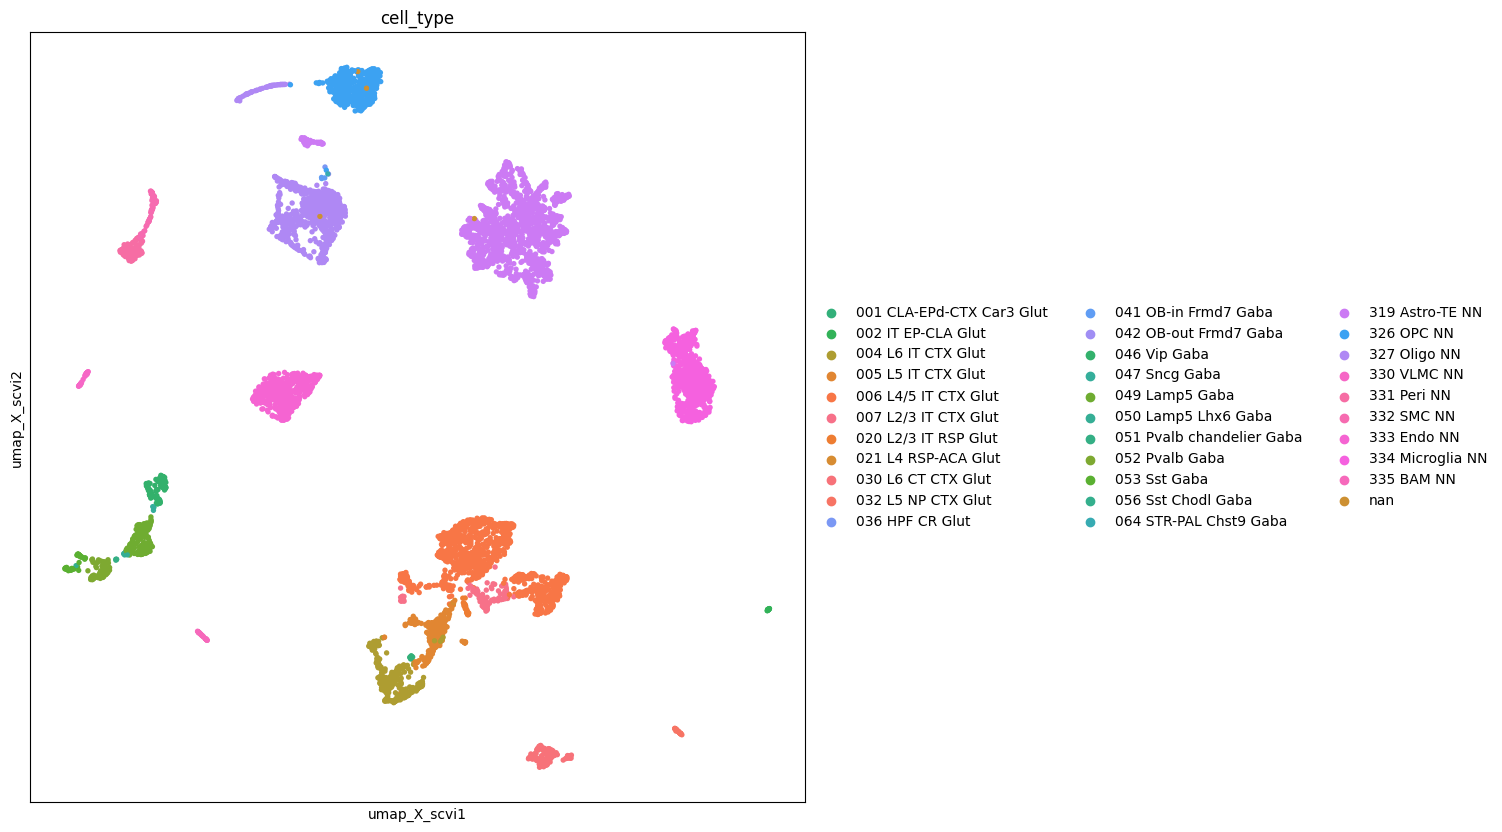

In [31]:
_ = mapping_sc_to_st.fig.plot_rep_umap_pca(mc_adata, color_df = cell_type_color, do_pca = False)

In [ ]:
# --- exports used by 02.run_example.ipynb ---
mc_out = EXPORT_DIR / 'adata_sc_mouse_brain_MOp.h5ad'
st_out = EXPORT_DIR / 'adata_st_mouse_brain_MOp.h5ad'
print('Writing:', mc_out)
mc_adata.write_h5ad(mc_out)
print('Writing:', st_out)
adata_st_toy.write_h5ad(st_out)